In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [2]:
dataframe = pd.read_csv(
    "https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Pokemon.csv",
)
dataframe.head()

,SN,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SN           800 non-null    int64 
 1   Name         800 non-null    object
 2   Type 1       800 non-null    object
 3   Type 2       414 non-null    object
 4   HP           800 non-null    int64 
 5   Attack       800 non-null    int64 
 6   Defense      800 non-null    int64 
 7   Sp. Attack   800 non-null    int64 
 8   Sp. Defense  800 non-null    int64 
 9   Speed        800 non-null    int64 
 10  Generation   800 non-null    int64 
 11  Legendary    800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


### **Задача** Выберите бинарную переменную (или сконструируйте из количественной)

Из данного списка можно назначить переменную `Legendary` - `target`

### **Задача** Выберите несколько объясняющих переменных

В качестве объясняющих переменных можно выбрать - `HP` `Attack` `Defense` `Sp. Attack` `Sp. Defense` `Speed` `Generation`

### **Задача** Разделите датасет на обучающую, валидационную и тестовую выборки

In [4]:
train_features, test_features, train_target, test_target = train_test_split(
    dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation"]],
    dataframe["Legendary"],
    test_size=0.4,
    random_state=42,
    stratify=dataframe["Legendary"],
)

validate_features, test_features, validate_target, test_target = train_test_split(
    test_features,
    test_target,
    test_size=0.5,
    random_state=42,
    stratify=test_target,
)

### Общий код и вспомогательные методы

Препроцессор для обработки данных, для всех моделей один и тот же

In [5]:
preprocessor = ColumnTransformer(
    transformers=(
        (
            "num",
            StandardScaler(),
            make_column_selector(dtype_include=["int64"]),
        ),
    ),
)

Отображение confusion matrix и отчета о качестве классификации можно выделить в функцию

In [6]:
from collections.abc import Iterable


def clf_report(pipeline: Pipeline | GridSearchCV, test_features: Iterable, test_target: Iterable) -> None:
    """Отображение confusion matrix и classification_report."""
    test_predict = pipeline.predict(test_features)
    conf_m = confusion_matrix(y_true=test_target, y_pred=test_predict)
    disp = ConfusionMatrixDisplay(conf_m)
    disp.plot()
    plt.show()
    print(classification_report(test_target, test_predict))

### **Задача** Обучите модели StackingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

#### StackingClassifier

In [7]:
base_estimators = [
    ("logistic", LogisticRegression(random_state=42, n_jobs=-1)),
    ("k_neighbors", KNeighborsClassifier(n_jobs=-1)),
    ("svc", SVC(random_state=42)),
]
final_estimator = LogisticRegression(random_state=42, n_jobs=-1)
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5, n_jobs=-1)
stacking_pipeline = Pipeline(
    [("preprocessing", preprocessor), ("classifier", stacking_clf)],
)
stacking_pipeline.fit(train_features, train_target)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=(('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eff4483ef10>),))),
                ('classifier',
                 StackingClassifier(cv=5,
                                    estimators=[('logistic',
                                                 LogisticRegression(n_jobs=-1,
                                                                    random_state=42)),
                                                ('k_neighbors',
                                                 KNeighborsClassifier(n_jobs=-1)),
                                                ('svc', SVC(random_state=42))],
                                    final_estimator=LogisticRegression(n_jobs=-1,
                                                                       random_state=42),
                                    n_jobs=-1))])

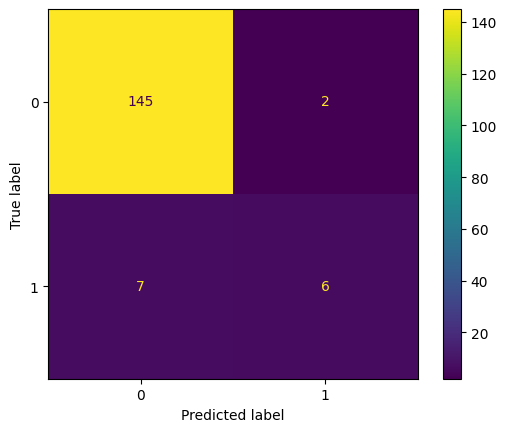

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       147
        True       0.75      0.46      0.57        13

    accuracy                           0.94       160
   macro avg       0.85      0.72      0.77       160
weighted avg       0.94      0.94      0.94       160



In [8]:
clf_report(stacking_pipeline, test_features, test_target)

#### BaggingClassifier

In [9]:
bagging_pipeline = Pipeline((("preprocessor", preprocessor), ("model", BaggingClassifier(random_state=42, n_jobs=-1))))
bagging_pipeline.fit(train_features, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=(('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eff4483ef10>),))),
                ('model', BaggingClassifier(n_jobs=-1, random_state=42))])

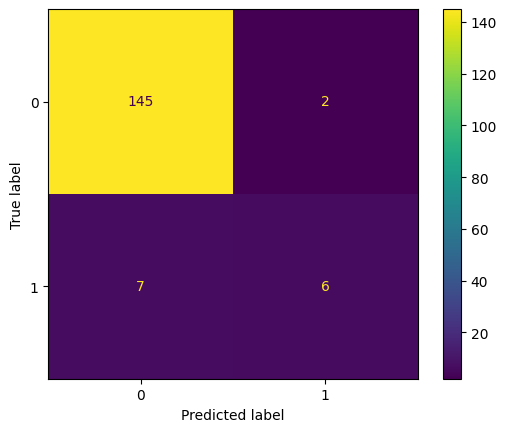

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       147
        True       0.75      0.46      0.57        13

    accuracy                           0.94       160
   macro avg       0.85      0.72      0.77       160
weighted avg       0.94      0.94      0.94       160



In [10]:
clf_report(bagging_pipeline, test_features, test_target)

#### RandomForestClassifier

In [11]:
random_forest_pipeline = Pipeline(
    (("preprocessor", preprocessor), ("model", RandomForestClassifier(random_state=42, n_jobs=-1)))
)
random_forest_pipeline.fit(train_features, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=(('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eff4483ef10>),))),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

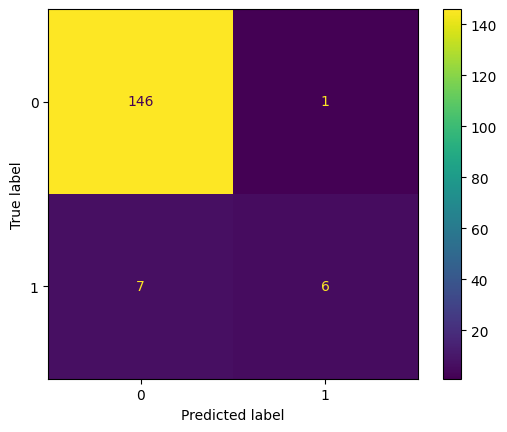

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       147
        True       0.86      0.46      0.60        13

    accuracy                           0.95       160
   macro avg       0.91      0.73      0.79       160
weighted avg       0.95      0.95      0.94       160



In [12]:
clf_report(random_forest_pipeline, test_features, test_target)

#### AdaBoostClassifier

In [13]:
ada_boost_pipeline = Pipeline((("preprocessor", preprocessor), ("model", AdaBoostClassifier(random_state=42))))
ada_boost_pipeline.fit(train_features, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=(('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eff4483ef10>),))),
                ('model', AdaBoostClassifier(random_state=42))])

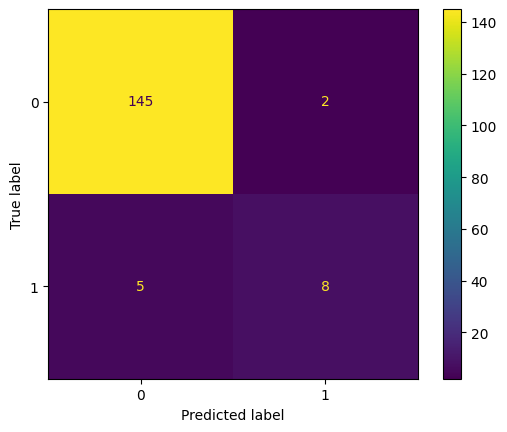

              precision    recall  f1-score   support

       False       0.97      0.99      0.98       147
        True       0.80      0.62      0.70        13

    accuracy                           0.96       160
   macro avg       0.88      0.80      0.84       160
weighted avg       0.95      0.96      0.95       160



In [14]:
clf_report(ada_boost_pipeline, test_features, test_target)

### **Задача** Проведите подбор гиперпараметров с помощью GridSearchCV. Сделайте предсказания целевой переменной для тестовой выборки. Постройте матрицу ошибок и рассчитайте метрики качества.

#### StackingClassifier

Нужно сначала обучить каждую модель по отдельности.

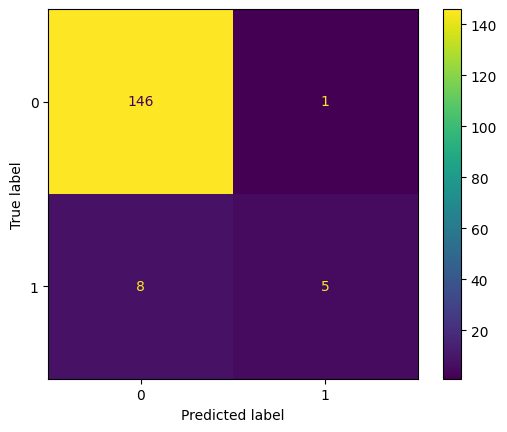

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       147
        True       0.83      0.38      0.53        13

    accuracy                           0.94       160
   macro avg       0.89      0.69      0.75       160
weighted avg       0.94      0.94      0.93       160



In [15]:
logistic_pipeline = Pipeline(
    (("preprocessor", preprocessor), ("model", LogisticRegression(random_state=42))),
)
logistic_pipeline.fit(train_features, train_target)
clf_report(logistic_pipeline, test_features, test_target)

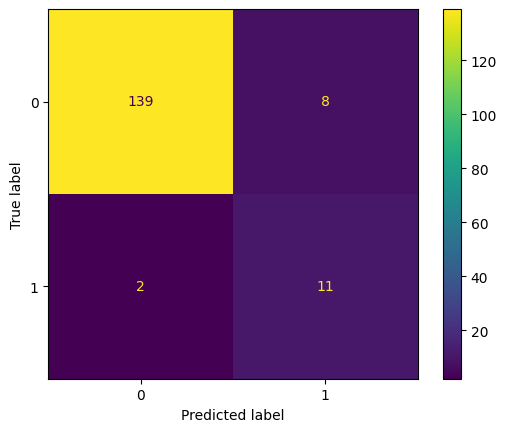

              precision    recall  f1-score   support

       False       0.99      0.95      0.97       147
        True       0.58      0.85      0.69        13

    accuracy                           0.94       160
   macro avg       0.78      0.90      0.83       160
weighted avg       0.95      0.94      0.94       160



In [16]:
param_grid = {
    "model__C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"],
    "model__class_weight": [None, "balanced"],
    "model__max_iter": [200, 500],
}
log_grid = GridSearchCV(logistic_pipeline, param_grid, cv=5, scoring="f1")
log_grid.fit(train_features, train_target)
clf_report(log_grid, test_features, test_target)

Для LogisticRegression с помощью GridSearchCV были подобраны параметры лучше

In [17]:
logistic_regression_best_params = log_grid.best_estimator_["model"].get_params()
pd.DataFrame([logistic_regression_best_params]).T

,0
C,0.00001
class_weight,None
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,200
multi_class,deprecated
n_jobs,None
penalty,l2


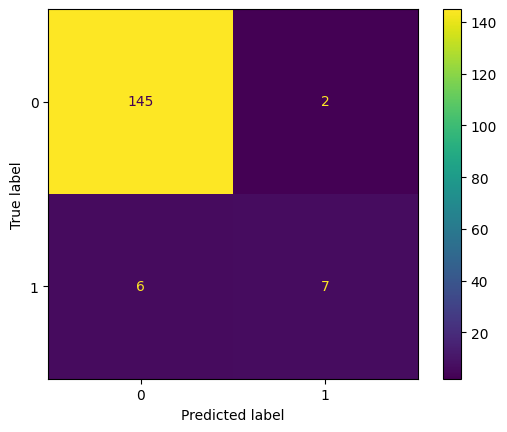

              precision    recall  f1-score   support

       False       0.96      0.99      0.97       147
        True       0.78      0.54      0.64        13

    accuracy                           0.95       160
   macro avg       0.87      0.76      0.80       160
weighted avg       0.95      0.95      0.95       160



In [18]:
k_neighbors_pipeline = Pipeline(
    (("preprocessor", preprocessor), ("model", KNeighborsClassifier(n_jobs=-1))),
)
k_neighbors_pipeline.fit(train_features, train_target)
clf_report(k_neighbors_pipeline, test_features, test_target)

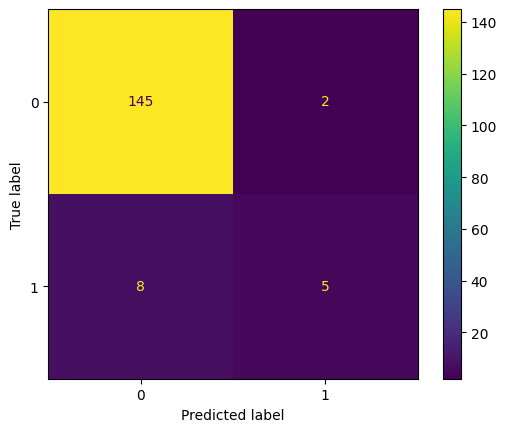

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       147
        True       0.71      0.38      0.50        13

    accuracy                           0.94       160
   macro avg       0.83      0.69      0.73       160
weighted avg       0.93      0.94      0.93       160



In [19]:
param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "minkowski"],
}
knn_grid = GridSearchCV(k_neighbors_pipeline, param_grid, cv=5, scoring="f1", n_jobs=-1)
knn_grid.fit(train_features, train_target)
clf_report(knn_grid, test_features, test_target)

In [20]:
results = pd.DataFrame(knn_grid.cv_results_)
results.sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__metric,param_model__n_neighbors,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.010024,0.001178,0.039633,0.002734,euclidean,9,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.461538,0.800000,0.714286,0.714286,0.500000,0.638022,0.132714,1
30,0.009533,0.001273,0.039755,0.003395,minkowski,9,uniform,"{'model__metric': 'minkowski', 'model__n_neigh...",0.461538,0.800000,0.714286,0.714286,0.500000,0.638022,0.132714,1
21,0.011615,0.001697,0.032692,0.004060,manhattan,11,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.500000,0.714286,0.666667,0.800000,0.500000,0.636190,0.119128,3
20,0.009051,0.000743,0.040156,0.007266,manhattan,11,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.500000,0.714286,0.666667,0.800000,0.500000,0.636190,0.119128,3
28,0.011369,0.001050,0.038386,0.003607,minkowski,7,uniform,"{'model__metric': 'minkowski', 'model__n_neigh...",0.461538,0.714286,0.666667,0.875000,0.461538,0.635806,0.158154,5
4,0.012931,0.002405,0.039483,0.006566,euclidean,7,uniform,"{'model__metric': 'euclidean', 'model__n_neigh...",0.461538,0.714286,0.666667,0.875000,0.461538,0.635806,0.158154,5
5,0.012019,0.002899,0.032471,0.001578,euclidean,7,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.461538,0.714286,0.666667,0.875000,0.461538,0.635806,0.158154,5
29,0.010219,0.001770,0.031434,0.004772,minkowski,7,distance,"{'model__metric': 'minkowski', 'model__n_neigh...",0.461538,0.714286,0.666667,0.875000,0.461538,0.635806,0.158154,5
18,0.009967,0.001340,0.038514,0.002697,manhattan,9,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.461538,0.800000,0.615385,0.800000,0.500000,0.635385,0.143630,9
31,0.009531,0.001809,0.030129,0.005053,minkowski,9,distance,"{'model__metric': 'minkowski', 'model__n_neigh...",0.461538,0.750000,0.714286,0.714286,0.500000,0.628022,0.121547,10


k-neighbors быстро переобучается при увеличении n_neighbors т. к на валидационных данных f1 score очень сильно падает

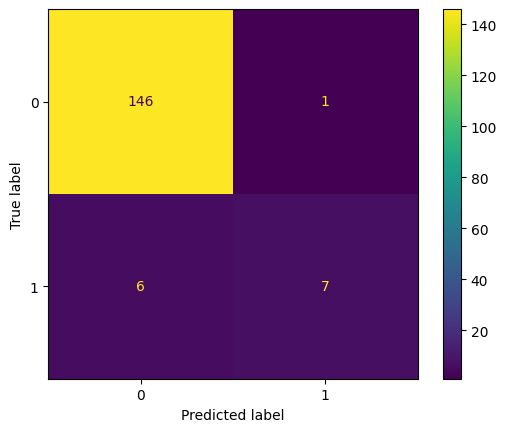

              precision    recall  f1-score   support

       False       0.96      0.99      0.98       147
        True       0.88      0.54      0.67        13

    accuracy                           0.96       160
   macro avg       0.92      0.77      0.82       160
weighted avg       0.95      0.96      0.95       160



In [21]:
param_grid = {
    "model__n_neighbors": [3, 5],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "minkowski"],
}
knn_grid = GridSearchCV(k_neighbors_pipeline, param_grid, cv=5, scoring="f1", n_jobs=-1)
knn_grid.fit(train_features, train_target)
clf_report(knn_grid, test_features, test_target)

Были подобраны следующие параметры которые позволили совсем незначительно улучшить метрику f1.

In [22]:
knn_best_params = knn_grid.best_estimator_["model"].get_params()
pd.DataFrame([knn_best_params]).T

,0
algorithm,auto
leaf_size,30
metric,manhattan
metric_params,None
n_jobs,-1
n_neighbors,3
p,2
weights,distance


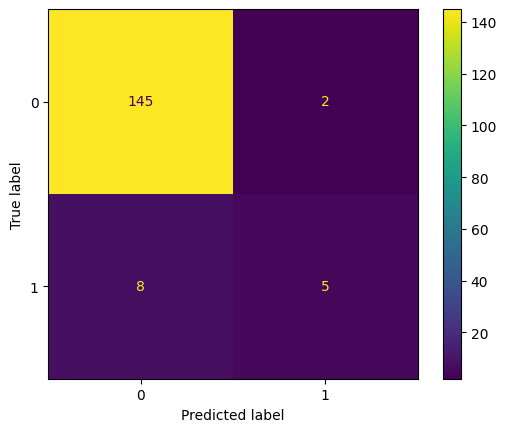

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       147
        True       0.71      0.38      0.50        13

    accuracy                           0.94       160
   macro avg       0.83      0.69      0.73       160
weighted avg       0.93      0.94      0.93       160



In [23]:
svc_pipeline = Pipeline(
    (("preprocessor", preprocessor), ("model", SVC(random_state=42))),
)
svc_pipeline.fit(train_features, train_target)
clf_report(svc_pipeline, test_features, test_target)

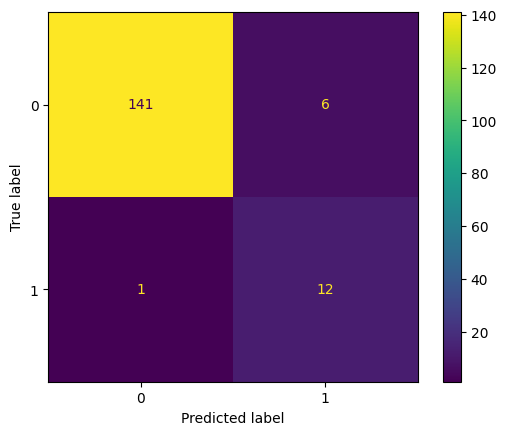

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



In [24]:
param_grid = [
    {
        "model__kernel": ["linear"],
        "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "model__class_weight": [None, "balanced"],
    },
    {
        "model__kernel": ["rbf"],
        "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "model__gamma": [0.001, 0.01, 0.1, 1, "scale", "auto"],
        "model__class_weight": [None, "balanced"],
    },
    {
        "model__kernel": ["poly"],
        "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "model__gamma": ["scale", "auto"],
        "model__degree": [2, 3, 4],
    },
]
svc_grid = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring="f1", n_jobs=-1)
svc_grid.fit(train_features, train_target)
clf_report(svc_grid, test_features, test_target)

Для svc удалось подобрать следующие параметры

In [25]:
svc_best_params = svc_grid.best_estimator_["model"].get_params()
pd.DataFrame([svc_best_params]).T

,0
C,100
break_ties,False
cache_size,200
class_weight,balanced
coef0,0.0
decision_function_shape,ovr
degree,3
gamma,0.01
kernel,rbf
max_iter,-1


Осталось подобрать параметры для final estimator

In [26]:
base_estimators_with_best_params = [
    ("logistic", LogisticRegression(**logistic_regression_best_params)),
    ("k_neighbors", KNeighborsClassifier(**knn_best_params)),
    ("svc", SVC(**svc_best_params)),
]
final_estimator = LogisticRegression(random_state=42)
stacking_clf = StackingClassifier(
    estimators=base_estimators_with_best_params, final_estimator=final_estimator, cv=5, n_jobs=-1
)
final_stacking_pipeline = Pipeline(
    [("preprocessing", preprocessor), ("classifier", stacking_clf)],
)
final_stacking_pipeline.fit(train_features, train_target)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=(('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eff4483ef10>),))),
                ('classifier',
                 StackingClassifier(cv=5,
                                    estimators=[('logistic',
                                                 LogisticRegression(C=1e-05,
                                                                    max_iter=200,
                                                                    random_state=42,
                                                                    solver='liblinear')),
                                                ('k_neighbors',
                                                 KNeighborsClassifier(metric='manhattan',
                                                                      n_jobs=-1,
                                                                      n_neighbors=3,
                                                                      weights='distance')),
                                                ('svc',
                                                 SVC(C=100,
                                                     class_weight='balanced',
                                                     gamma=0.01,
                                                     random_state=42))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1))])

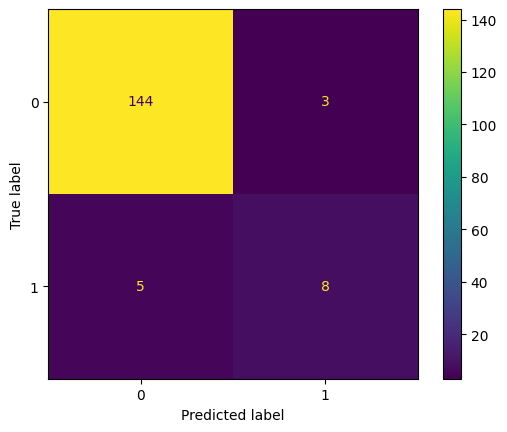

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



In [27]:
clf_report(final_stacking_pipeline, test_features, test_target)

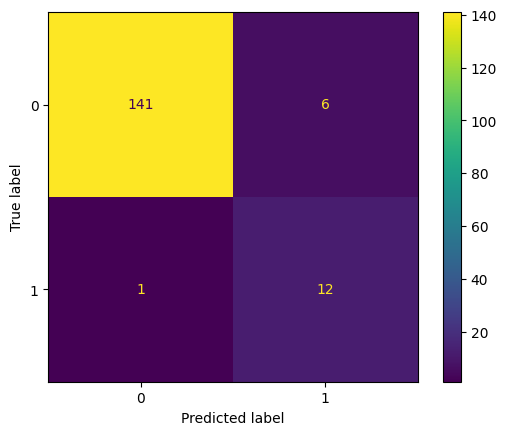

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



In [28]:
param_grid = {
    "classifier__final_estimator__C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__final_estimator__penalty": ["l1", "l2"],
    "classifier__final_estimator__solver": ["liblinear"],
    "classifier__final_estimator__class_weight": [None, "balanced"],
    "classifier__final_estimator__max_iter": [200, 500],
}
stacking_grid = GridSearchCV(final_stacking_pipeline, param_grid, cv=5, scoring="f1")
stacking_grid.fit(train_features, train_target)
clf_report(stacking_grid, test_features, test_target)

После подбора параметров для base estimator удалось получить весьма неплохие результаты.

#### BaggingClassifier

In [29]:
param_grid = [
    {
        "model__estimator": [DecisionTreeClassifier(random_state=42)],
        "model__estimator__max_depth": [3, 5, 10],
        "model__estimator__criterion": ["gini", "entropy"],
        "model__n_estimators": [10, 50, 100, 250, 500],
        "model__max_samples": [0.5, 0.7, 1.0],
        "model__max_features": [0.5, 0.7, 1.0],
    },
    {
        "model__estimator": [LogisticRegression(solver="liblinear", random_state=42)],
        "model__estimator__C": [0.0001, 0.001, 0.01],
        "model__estimator__penalty": ["l1", "l2"],
        "model__estimator__class_weight": ["balanced"],
        "model__estimator__max_iter": [500],
        "model__n_estimators": [10, 50, 100, 250],
        "model__max_samples": [0.5, 0.7, 1.0],
        "model__max_features": [0.5, 0.7, 1.0],
    },
]
bagging_pipeline = Pipeline(
    (
        ("preprocessor", preprocessor),
        ("model", BaggingClassifier(random_state=42, n_jobs=-1)),
    ),
)
bagging_grid = GridSearchCV(bagging_pipeline, param_grid, cv=5, scoring="f1", n_jobs=-1)
bagging_grid.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=(('preprocessor',
                                        ColumnTransformer(transformers=(('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7eff4483ef10>),))),
                                       ('model',
                                        BaggingClassifier(n_jobs=-1,
                                                          random_state=42)))),
             n_jobs=-1,
             param_grid=[{'model__estimator': [DecisionTreeClassifier(random_state=42)],
                          'model_...
                         {'model__estimator': [LogisticRegression(random_state=42,
                                                                  solver='liblinear')],
                          'model__estimator__C': [0.0001, 0.001, 0.01],
                          'model__estimator__class_weight': ['balanced'],
                          'model__estimator__max_iter': [500],
                          'model__estimator__penalty': ['l1', 'l2'],
                          'model__max_features': [0.5, 0.7, 1.0],
                          'model__max_samples': [0.5, 0.7, 1.0],
                          'model__n_estimators': [10, 50, 100, 250]}],
             scoring='f1')

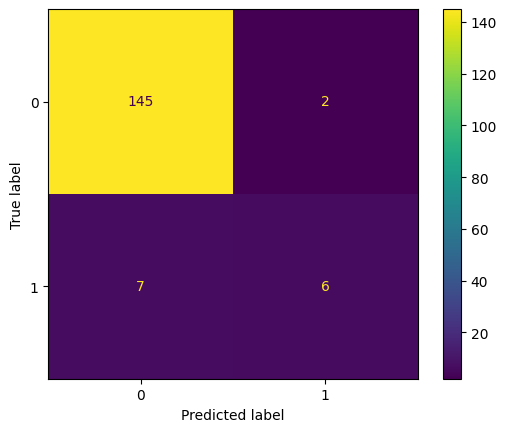

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       147
        True       0.75      0.46      0.57        13

    accuracy                           0.94       160
   macro avg       0.85      0.72      0.77       160
weighted avg       0.94      0.94      0.94       160



In [30]:
clf_report(bagging_grid, test_features, test_target)

Ансамбль из логистических регрессий дал результаты хуже чем решающие деревья. Не удалось подобрать параметры лучше, чем параметры по умолчанию.

#### RandomForestClassifier

In [31]:
random_forest_pipeline = Pipeline(
    (("preprocessor", preprocessor), ("model", RandomForestClassifier(random_state=42, n_jobs=-1))),
)
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 1, 3, 5],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2"],
    "model__class_weight": [None, "balanced"],
}
random_forest_grid = GridSearchCV(random_forest_pipeline, param_grid, cv=5, scoring="f1", n_jobs=-1)
random_forest_grid.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=(('preprocessor',
                                        ColumnTransformer(transformers=(('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7eff4483ef10>),))),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42)))),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__max_depth': [None, 1, 3, 5],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200, 300]},
             scoring='f1')

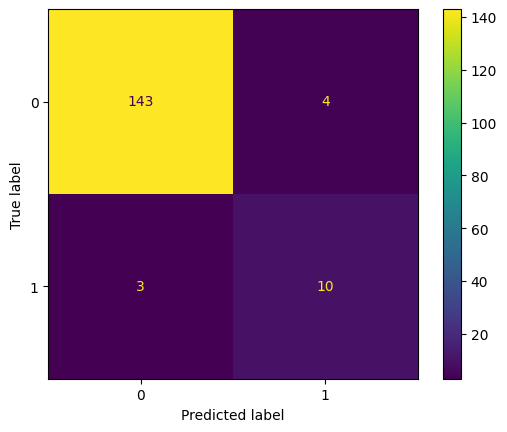

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       147
        True       0.71      0.77      0.74        13

    accuracy                           0.96       160
   macro avg       0.85      0.87      0.86       160
weighted avg       0.96      0.96      0.96       160



In [32]:
clf_report(random_forest_grid, test_features, test_target)

Удалось подобрать параметры лучше чем по умолчанию.

#### AdaBoostClassifier

In [33]:
ada_boost_pipeline = Pipeline((("preprocessor", preprocessor), ("model", AdaBoostClassifier(random_state=42))))
param_grid = [
    {
        "model__estimator": [DecisionTreeClassifier(random_state=42)],
        "model__estimator__max_depth": [1, 3, 5],
        "model__estimator__min_samples_split": [2, 5],
        "model__estimator__min_samples_leaf": [1, 2],
        "model__estimator__max_features": ["sqrt", "log2", None],
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.01, 0.1, 1.0],
    },
    {
        "model__estimator": [LogisticRegression(solver="liblinear", random_state=42)],
        "model__estimator__C": [0.0001, 0.001, 0.01],
        "model__estimator__penalty": ["l1", "l2"],
        "model__estimator__class_weight": ["balanced"],
        "model__estimator__max_iter": [500],
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.01, 0.1, 1.0],
    },
]
ada_boost_grid = GridSearchCV(ada_boost_pipeline, param_grid, cv=5, scoring="f1", n_jobs=-1)
ada_boost_grid.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=(('preprocessor',
                                        ColumnTransformer(transformers=(('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7eff4483ef10>),))),
                                       ('model',
                                        AdaBoostClassifier(random_state=42)))),
             n_jobs=-1,
             param_grid=[{'model__estimator': [DecisionTreeClassifier(random_state=42)],
                          'model__estimato...
                          'model__n_estimators': [50, 100, 200]},
                         {'model__estimator': [LogisticRegression(random_state=42,
                                                                  solver='liblinear')],
                          'model__estimator__C': [0.0001, 0.001, 0.01],
                          'model__estimator__class_weight': ['balanced'],
                          'model__estimator__max_iter': [500],
                          'model__estimator__penalty': ['l1', 'l2'],
                          'model__learning_rate': [0.01, 0.1, 1.0],
                          'model__n_estimators': [50, 100, 200]}],
             scoring='f1')

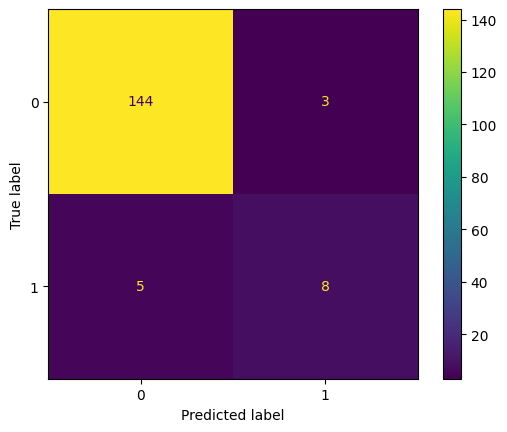

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



In [34]:
clf_report(ada_boost_grid, test_features, test_target)

Снова ансамбль из логистических регрессий дал результаты хуже чем решающие деревья. Не удалось подобрать параметры лучше, чем параметры по умолчанию.

### **Задача** Сделайте выводы относительно полученных моделей и их качества.

#### StackingClassifier

Изначально метрики были следующими:

|precision|recall|f1-score|
|:-------:|:----:|:------:|
|0.75     |0.46  |0.57    |

C помощью GridSearchCV были обучены модели по отдельности, а в конце и final estimator. Удалось получить следующие метрики:

|precision|recall|f1-score|
|:-------:|:----:|:------:|
|0.67     |0.92  |   0.77 |

Для данной задачи важным является показатель recall и он получился 0.92. Это отличный результат учитывая сильный дисбаланс классов. Также стоит отметить хороший баланс между precision и recall - 0.77.

Данная модель отлично находит легендарных покемонов, но есть много ложных срабатываний, что для данной задачи приемлемо. На тестовых данных полнота составила 92%, а точность 67% т. е из всех предсказанных результатов ложных 33%, а потеряно легендарных покемонов всего 8%.

#### BaggingClassifier

Не удалось подобрать параметры лучше, чем параметры по умолчанию. Метрики следующие:

|precision|recall|f1-score|
|:-------:|:----:|:------:|
|0.75     |0.46  |0.57    |

Для решения данной задачи recall слишком низкий, да и в целом метрики получились плохими. 

Данная модель упускает больше половины легендарных покемонов - это не приемлемо для решаемой задачи.

#### RandomForestClassifier

Изначально метрики были следующими:

|precision|recall|f1-score|
|:-------:|:----:|:------:|
|0.86     |0.46  |0.60    |

С помощью подбора параметров удалось их улучшить:

|precision|recall|f1-score|
|:-------:|:----:|:------:|
|0.71     |0.77  |0.74    |

В целом очень хорошие результаты, за счет небольшого ухудшения precision, удалось выровнять модель и получить высокий f1-score и recall.

Данная модель хорошо находит легендарных покемонов, но есть ложные срабатывания, что для данной задачи приемлемо. На тестовых данных полнота составила 77%, а точность 71% т. е из всех предсказанных результатов ложных 29%, а потеряно легендарных покемонов 23%.

#### AdaBoostClassifier

Наилучшие метрики с параметрами по умолчанию:

|precision|recall|f1-score|
|:-------:|:----:|:------:|
|0.80     |0.62  |0.70    |

Неплохие результаты, особенно precision и f1-score. Возможно не так хорошо для решения текущей задачи.

Данная модель неплохо находит легендарных покемонов, при этом относительно остальных моделей имеет наименьшее количество ложных срабатываний. На тестовых данных полнота составила 62% и может быть недостаточной, а точность 80% т. е из всех предсказанных результатов ложных 20%, а потеряно легендарных покемонов 38%.

### **Задача** Сравните качество ансамблей с качеством одиночных классификаторов

При обучении Stacking Classifier обучались одиночные модели и объединялись в ансамбль. Можно взять их метрики для сравнения:

|Модель   |precision|recall|f1-score|
|---------|:-------:|:----:|:------:|
|Logistic |0.58     |0.85  |0.69    |
|KNN      |0.88     |0.54  |0.67    |
|SVC      |0.67     |0.92  |0.77    |

В целом метрики SVC совпадают со StackingClassifier, наверное в основном учитываются предсказания этой модели. Одиночные классификаторы на этом датасете показывают очень хорошие результаты. Возможно они чуть хуже справляются с дисбалансом классов чем ансамбли.